In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score

from scipy.stats import entropy
import random

import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn import tree


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

def multiply_weight(X,w):
    return np.dot(X,w)

def generate_particle(num_parameters):
    '''
    we generate num_parameters parameters with values between 0 and 1 random uniform
    '''
    particle=np.array([np.random.uniform() for i in range(num_parameters)])
    return particle

def generate_n_particles(n,num_parameters):
    particles=[]
    for i in range(n):
        particles.append(generate_particle(num_parameters))
    return np.array(particles)

In [4]:
def get_entropy_from_groups(new_entropies,count_items):
    overall_new_entropy = 0
    
    # Calculating the total number of items
    total_items = sum(count_items)
    
    for i in range(len(new_entropies)):
        # Calculating the proportion of items in the current partition
        proportion = count_items[i] / total_items
        
        # Adding the entropy of the current partition weighted by its proportion to the overall new entropy
        overall_new_entropy += new_entropies[i] * proportion
        
    return overall_new_entropy    


def calc_entropy_from_probabilities(list_probas):
    '''
    list_probas is the list of probabiities
    the formula for entropy is
    sum(-proba*log(proba))
    
    '''
    
    entropy_value = 0

    for proba in list_probas:
        # If the probability is not zero
        if proba != 0:
            entropy_value += -proba * np.log(proba)
     
    return entropy_value

def calculate_probabilities(list_labels, uniq_labels):
    '''
    this function calculates the probabilities of each label in the list of labels
    it is calculated by number of labels in class A/all labels
    number of labels in class B/all labels
    and so on
    '''
    
    # A dictionary to store the probabilities
    probabilities = dict.fromkeys(uniq_labels, 0)
    
    # Total number of labels
    total_labels = len(list_labels)
    
    for label in uniq_labels:
        # Counting the number of times the label occurs in the list
        count = list_labels.count(label)
        
        # Calculating the probability of the label
        probability = count / total_labels
        
        # Storing the calculated probability in the dictionary
        probabilities[label] = probability
        
    return probabilities    

def objective_function(X,y,particle):
    '''
    this is binary classification objective
    using entropy
    '''
    res=multiply_weight(X,particle[0:X.shape[1]])
#     print(res.shape)
    res = (res-np.min(res))/(np.max(res)-np.min(res))

    # make two groups
    group1=[]
    group2=[]

    for i in range(res.shape[0]):
    #     print(i,res[i],particle[-1])
        if res[i]<particle[-1]:
            group1.append(y[i])
        else:
            group2.append(y[i])



    proba_gr1=calculate_probabilities(group1,np.unique(group1).tolist())
    proba_gr1=list(proba_gr1.values()) 
    entropy_group1=calc_entropy_from_probabilities(proba_gr1)
    count_group1=len(proba_gr1)

    proba_gr2=calculate_probabilities(group2,np.unique(group2).tolist())
    proba_gr2=list(proba_gr2.values()) 
    entropy_group2=calc_entropy_from_probabilities(proba_gr2)
    count_group2=len(proba_gr2)


    new_entropies=[entropy_group1,entropy_group2]
    count_items=[count_group1,count_group2]
    overall_new_entropy=get_entropy_from_groups(new_entropies,count_items)

#     print(overall_new_entropy)
    return overall_new_entropy
    


# uncomment below when you want to use accuracy


# def objective_function(X,y,particle):
#     '''
#     this is binary classification objective
#     using 1-accuracy
#     '''
#     res=multiply_weight(X,particle[0:X.shape[1]])
#     res = (res-np.min(res))/(np.max(res)-np.min(res))
#     res[res<particle[-1]]=0
#     res[res>=particle[-1]]=1
#     acc=accuracy_score(y,res)
#     loss=1-acc    
#     return loss
    
    
    
    
def split_left_right(X,y,particle):
    
    res=multiply_weight(X,particle[:-1])
    res = (res-np.min(res))/(np.max(res)-np.min(res))
#     print("Splitting",res,"on",particle[-1])    
    # apply threshold to get the split    
    X_left=X[res<particle[-1]]
    X_right=X[res>=particle[-1]]
    y_left=y[res<particle[-1]]
    y_right=y[res>=particle[-1]]
#     print(X_left.shape,X_right.shape)
    return X_left,y_left,X_right,y_right

    

In [5]:
def update_velocity_of_particle(particle,velocity, best_particle, gbest_particle, w_min=0.5, max=1.0, c=0.1):
    new_vel=np.array([0.0 for i in range(particle.shape[0])])
    # Randomly generate r1, r2 and inertia weight from normal distribution
    r1 = random.uniform(0,max)
    r2 = random.uniform(0,max)
    w = random.uniform(w_min,max)
    c1=c
    c2=c
    # Calculate new velocity    
    for i in range(new_vel.shape[0]):
        component1=w*velocity[i]
        component2=c1*r1*(best_particle[i]-particle[i])
        component3=c2*r2*(gbest_particle[i]-particle[i])
#         print(component1,component2,component3)
        new_vel[i]= component1+component2 +component3
#         print(new_vel[i])
#     print("thresh",new_vel[-1])
    return new_vel


def update_position(particle, velocity):
  # Move particles by adding velocity
    new_particle = particle + velocity
    return new_particle

### Load data

In [8]:
# for algeria forest fire data
df=pd.read_csv("/content/drive/MyDrive/coding_teamwork/planning_relax.csv")

df.head()

X=df.iloc[:,3:-1].values
y=df.iloc[:,-1].values




# for breast cancer
# bc_data = datasets.load_breast_cancer()
# X = bc_data.data
# y = bc_data.target

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)


# normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
print(X_train[0],y_train[0])
print(X_test[0],y_test[0])

(121, 9) (121,) (61, 9) (61,)
[0.62344498 0.58173077 0.48434783 0.78607724 0.59059406 0.85
 0.66230769 0.39670738 0.36555024] 0
[0.55545455 0.43028846 0.66618357 0.7078252  0.36435644 1.
 0.94384615 0.06744557 0.45789474] 0


### Train and test model

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def PSO_on_X_y(X_train, y_train, X_test, y_test, num_particles=5, num_epochs=10):
    # Initialization
    num_particles = num_particles
    particles = generate_n_particles(num_particles, X_train.shape[1] + 1)
    particles_best = deepcopy(particles)
    gbest_particle = particles[0]

    velocities = [[0.0 for j in range(particles.shape[1])] for i in range(particles.shape[0])]
    
    # Color options for particles
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    for i in range(particles.shape[0]):
        particle = particles[i]
        loss = objective_function(X_train, y_train, particle)
        loss_best_this_particle = objective_function(X_train, y_train, particles_best[i])
        if loss < loss_best_this_particle:
            particles_best[i] = particle
        loss_best_global = objective_function(X_train, y_train, gbest_particle)
        if loss < loss_best_global:
            gbest_particle = particle
    
    # ...

    # Run the PSO
    num_epochs = num_epochs
    train_losses = [[] for i in range(particles.shape[0])]

    for epoch in range(num_epochs):
        for i in range(particles.shape[0]):
            particle=particles[i]
            if i <len(colors):
                plt.scatter(particle[0],particle[-1],color=colors[i])
        
            velocity = velocities[i]
            best_particle = particles_best[i]
            new_vel = update_velocity_of_particle(particle, velocity, best_particle, gbest_particle)
            velocities[i] = new_vel
            particles[i] = update_position(particle, new_vel)
        

        for i in range(particles.shape[0]):
            particle = particles[i]
            loss = objective_function(X_train, y_train, particle)
            train_losses[i].append(loss)
            loss_best_this_particle = objective_function(X_train, y_train, particles_best[i])
            if loss < loss_best_this_particle:
                particles_best[i] = particle
            loss_best_global = objective_function(X_train, y_train, gbest_particle)
            if loss < loss_best_global:
                gbest_particle = particle

    return gbest_particle


In [13]:

def recursive_PSO(X_train,y_train,X_test,y_test,current_node_number,num_particles=10,num_epochs=10,):
#     print("CAlled recursive")
    if current_node_number>=max_num_nodes:
        return
    global dtree
    best_particle=PSO_on_X_y(X_train,y_train,X_test,y_test,num_particles,num_epochs)
#     print("current_node_number",current_node_number)
    dtree[current_node_number]={}
    dtree[current_node_number]["weights"]=best_particle
    dtree[current_node_number]["samples"]=X_train.shape[0]
    res=multiply_weight(X_train,best_particle[:-1])
    
    dtree[current_node_number]["min"]=np.min(res)
    dtree[current_node_number]["max"]=np.max(res)
    loss_val=objective_function(X_train,y_train,best_particle)
#     print(X_train.shape[0],y_train.shape[0],loss_val)
    if loss_val==0:
        return
    X_train_left,y_train_left,X_train_right,y_train_right=split_left_right(X_train,y_train,best_particle)
    
    if X_train_left.shape[0]<=1:
        return 
    if X_train_right.shape[0]<=1:
        return
    left_node_number=2*current_node_number+1
#     print("Split shapes",X_train_left.shape,X_train_right.shape)
    recursive_PSO(X_train_left,y_train_left,X_test,y_test,left_node_number,num_particles,num_epochs)
    right_node_number=2*current_node_number+2
    recursive_PSO(X_train_right,y_train_right,X_test,y_test,right_node_number,num_particles,num_epochs)    
    

def solve(dtree,row,which_node=0):    
#     print("Looking at which_node",which_node)
    val=multiply_weight(row,dtree[which_node]["weights"][:-1])
    range_val=dtree[which_node]["max"]-dtree[which_node]["min"]
    normalized=(val-dtree[which_node]["min"])/range_val
    threshold=dtree[which_node]["weights"][-1]
#     print(normalized,threshold)
    if normalized<threshold:
        # left child
        label=0
        child_node_number=which_node*2+1
    else:
        # right child
        label=1
        child_node_number=which_node*2+1
#     print("child_node_number",child_node_number)
    if child_node_number>=max_num_nodes:
        return label
    if not dtree[child_node_number]:
        return label
        
    return solve(dtree,row,child_node_number)
        

In [14]:
from sklearn.tree import DecisionTreeClassifier


Score to beat is 0.47540983606557374
10 10 10 1023 0.6721311475409836
10 20 10 1023 0.36065573770491804
20 10 10 1023 0.6557377049180327


<ipython-input-4-2ac82b260d14>:67: RuntimeWarning: invalid value encountered in true_divide
  res = (res-np.min(res))/(np.max(res)-np.min(res))
<ipython-input-13-11f3aa019d5e>:36: RuntimeWarning: divide by zero encountered in double_scalars
  normalized=(val-dtree[which_node]["min"])/range_val


20 20 10 1023 0.4098360655737705


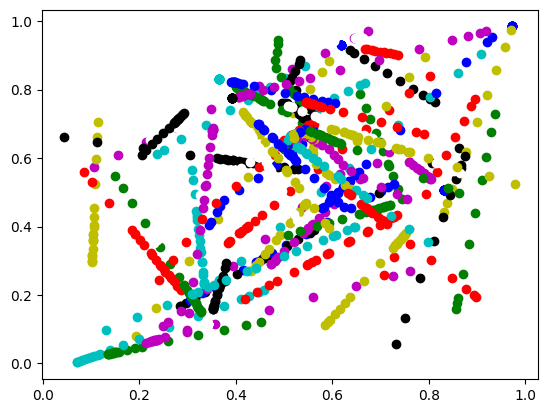

In [15]:
############################################
########### below for decision tree ########
decision_tree = DecisionTreeClassifier(random_state=0,max_depth=10)
decision_tree = decision_tree.fit(X_train,y_train)
acc_dtree=accuracy_score(decision_tree.predict(X_test),y_test)
print("Score to beat is",acc_dtree)

############################################
############################################
########### our algorithm below ###########

dic_results={}
dic_results["num_particles"]=[]
dic_results["num_epochs"]=[]
dic_results["tree_height"]=[]
dic_results["acc"]=[]
dic_results["acc_dtree"]=[]

for num_particles in [10,20]:
    for num_epochs in [10,20]:
        tree_height=10


        max_num_nodes=2**(tree_height)-1
        current_node_number=0

        dtree=[None for i in range(max_num_nodes)]
        # will contain the particles at each node of the tree
        recursive_PSO(X_train,y_train,X_test,y_test,current_node_number,num_particles,num_epochs)
        y_labels=[]
        for i in range(X_test.shape[0]):
            y_labels.append(solve(dtree,X_test[i],0))            

        acc=accuracy_score(y_labels,y_test)
        print(num_particles,num_epochs,tree_height,max_num_nodes,acc)
        dic_results["num_particles"].append(num_particles)
        dic_results["num_epochs"].append(num_epochs)
        dic_results["tree_height"].append(tree_height)
        dic_results["acc"].append(acc)
        dic_results["acc_dtree"].append(acc_dtree)

In [16]:
df_results=pd.DataFrame(dic_results)
df_results=df_results.sort_values(by=["acc"],ascending=False)

In [17]:
df_results

num_particles  num_epochs  tree_height       acc  acc_dtree
0             10          10           10  0.672131    0.47541
2             20          10           10  0.655738    0.47541
3             20          20           10  0.409836    0.47541
1             10          20           10  0.360656    0.47541

In [18]:
if list(df_results["acc"])[0]>list(df_results["acc_dtree"])[0]:
    print("PSO wins for this dataset, report your results")
else:
    print("PSO couldnt win, try more parameters?")

PSO wins for this dataset, report your results
